***Import Libraries***

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

***Hyper Parameters***

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

k = 2   #메시지 비트수
M = 2**k    #전송 가능한 메시지 수
n = 2   #인코딩 출력 차원

SNR_dB = np.arange(-2,16, 1)
idx = 8 #훈련 코드의 SNR_dB 과 매칭

num_msgs = 100000

ENC_MODEL_PATH = f"M={M}/Enc_M={M}_SNR={idx}.pth"
DEC_MODEL_PATH = f"M={M}/Dec_M={M}_SNR={idx}.pth"

***Functions***

In [3]:
def Normalization(s):
    snorm = torch.linalg.norm(s, dim=1)
    snorm = torch.tile(snorm.unsqueeze(1), [1,n])
    snorm = snorm.to(device)
    return s/snorm


def Awgn(x, noise_var):
    noise = torch.randn((x.size(0),n))
    noise = noise.to(device)
    out = x + np.sqrt(noise_var) * noise
    return out


def one_hot_encoding(val):
    xx = torch.eye(M)
    xx = xx.to(device)
    return xx[val] 


def one_hot_decoding(prob):
    arg_list = []
    for p in prob:
        arg_max = torch.argmax(p)

        arg_max.to(device)

        arg_list.append(arg_max)
        arg_list = list(map(int, arg_list))

    arg_list = torch.LongTensor(arg_list)
    encoded_arg_list = one_hot_encoding(arg_list)

    return encoded_arg_list

***Model***

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(M, M),
            nn.ReLU(),
            nn.Linear(M, n)
        )

    def forward(self, s):
        out = self.encoder(s)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(n, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.Softmax(dim=1)
        )

    def forward(self, y):
        out = self.decoder(y)
        return out

***BLER***

In [5]:
BLER = []

#===== Model Generate =====#

encoder = Encoder() 
decoder = Decoder()
encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load(ENC_MODEL_PATH))
decoder.load_state_dict(torch.load(DEC_MODEL_PATH))

with open(f'M={M}/BLER_M={M}_SNR={idx}.txt', 'a') as f:
    f.truncate(0)

for i, (snr) in enumerate(SNR_dB):
    SNR = 10**(snr/10)
    N = 1/SNR   #Noise std

    print(f"SNR = {snr} Noise Var = {N}")

    #===== Test =====#
    err = 0
    a = 0
                
    while a != M:
        msg = torch.randint(0, M, (num_msgs,))#msg
        a = torch.max(msg) + 1

    msg.to(device)

    s = one_hot_encoding(msg) #s
    encoded_s = encoder(s)  #x
    x = Normalization(encoded_s)
    y = Awgn(x, N)    #y
    p = decoder(y)
    s_hat = one_hot_decoding(p)

    err = torch.sum(torch.abs(s - s_hat)) / 2
    err = err.cpu().detach().numpy()
    
    BLER.append(err/num_msgs)
    print(f"Block Error Rate : {err/num_msgs}\n")
    
    with open(f'M={M}/BLER_M={M}_SNR={idx}.txt', 'a') as f:
        f.write(f'{snr} {BLER[i]}\n')

print("test finished!\n")


SNR = -2 Noise Var = 1.5848931924611134
Block Error Rate : 0.4912

SNR = -1 Noise Var = 1.2589254117941673
Block Error Rate : 0.45813

SNR = 0 Noise Var = 1.0
Block Error Rate : 0.42107

SNR = 1 Noise Var = 0.7943282347242815
Block Error Rate : 0.37991

SNR = 2 Noise Var = 0.6309573444801932
Block Error Rate : 0.33668

SNR = 3 Noise Var = 0.5011872336272724
Block Error Rate : 0.29182

SNR = 4 Noise Var = 0.39810717055349726
Block Error Rate : 0.24446

SNR = 5 Noise Var = 0.31622776601683794
Block Error Rate : 0.19861

SNR = 6 Noise Var = 0.251188643150958
Block Error Rate : 0.15169

SNR = 7 Noise Var = 0.199526231496888
Block Error Rate : 0.1106

SNR = 8 Noise Var = 0.15848931924611132
Block Error Rate : 0.07436

SNR = 9 Noise Var = 0.1258925411794167
Block Error Rate : 0.04505

SNR = 10 Noise Var = 0.1
Block Error Rate : 0.02483

SNR = 11 Noise Var = 0.07943282347242814
Block Error Rate : 0.0127

SNR = 12 Noise Var = 0.06309573444801933
Block Error Rate : 0.00472

SNR = 13 Noise Var =

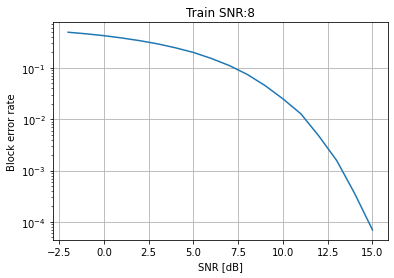

In [6]:
plt.plot(SNR_dB, BLER)

plt.xlabel("SNR [dB]")
plt.ylabel("Block error rate")
plt.yscale('log')
plt.title(f"Train SNR:{idx}")


plt.grid()
plt.show()